# Time series project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import networkx as nx
from collections import deque, OrderedDict

Useful function to calculate Laplacian and its conjugate.

In [2]:
def edge_list(p: int):
    """
    Returns list of (i,j) pairs with i>j in a fixed order.
    Length = p*(p-1)//2
    """
    edges = []
    for j in range(p):
        for i in range(j+1, p):
            edges.append((i, j))

    edges = np.array(edges)
    return edges

def L_operator(w: np.ndarray, p: int, edges=None) -> np.ndarray:
    """
    Laplacian operator L: 
    Builds Theta = Lw such that:
      Theta_ij = -w_k for (i,j) edge with i>j
      Theta is symmetric
      Theta_ii = -sum_{j!=i} Theta_ij  (so rows sum to 0)
    Matches Definition of Laplacian set S_Theta and operator L.  (paper Sec 3.1)

    See the paper for more information, specifically [page 13] !
    """

    if edges is None:
        edges = edge_list(p)
    m = p * (p - 1) // 2
    assert w.shape == (m,), f"w must have shape ({m},), got {w.shape}"

    Theta = np.zeros((p, p))
    for k, (i, j) in enumerate(edges):

        Theta[i, j] = -w[k]
        Theta[j, i] = -w[k]

    Theta[np.diag_indices(p)] = -Theta.sum(axis=1)

    return Theta

def L_adjoint(Y: np.ndarray, p: int, edges=None) -> np.ndarray:

    """
    Adjoint operator L*: 
    For each edge (i>j), returns:
      [L*Y]_k = Y_ii - Y_ij - Y_ji + Y_jj

    See paper for adjoint formula, specifically [page 14]
    """

    if edges is None:
        edges = edge_list(p)

    assert Y.shape == (p, p), f"Y must have shape ({p},{p}), got {Y.shape}"

    m = p * (p - 1) // 2
    out = np.zeros(m)

    for k, (i, j) in enumerate(edges):
        out[k] = Y[i, i] - Y[i, j] - Y[j, i] + Y[j, j]

    return out

def adjacency_from_theta(theta: np.ndarray, thr=1e-5):
    """
    For Laplacian Theta:
      off-diagonals are negative weights: Theta[i,j] = -w_ij
    """
    W = np.maximum(-theta, 0.0)
    np.fill_diagonal(W, 0.0)
    W[W < thr] = 0.0
    return W

Test the correctess of the Adjoint and the Laplacian Matrix

In [3]:
p = 100
edges = edge_list(p)

m = p*(p-1)//2
w = np.arange(1, m+1)
Theta = L_operator(w, p, edges)
Y = np.random.randn(p, p)

left = np.sum(Theta * Y)  
right = np.dot(w, L_adjoint(Y, p, edges))
print("adjoint error:", np.isclose(left - right, 0), np.abs(left - right))

adjoint error: True 2.3283064365386963e-10


We can see that the scalar product is preserved, so the adjoint formula is correct. This part here plots the connected compoennt and shows the eigen values representing the numbe of connected compoenents.

Connected components (networkx): 3
Connected components (spectral): 3
Smallest eigenvalues: [-6.64399091e-15  9.92695509e-16  1.71737624e-15  2.49804403e+00
  2.99499502e+00  3.16299152e+00  3.22890039e+00  3.24472418e+00
  3.41196528e+00  3.55024473e+00]


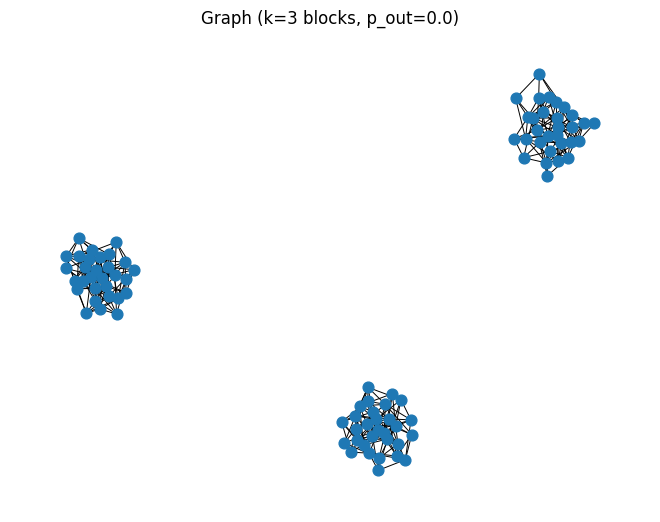

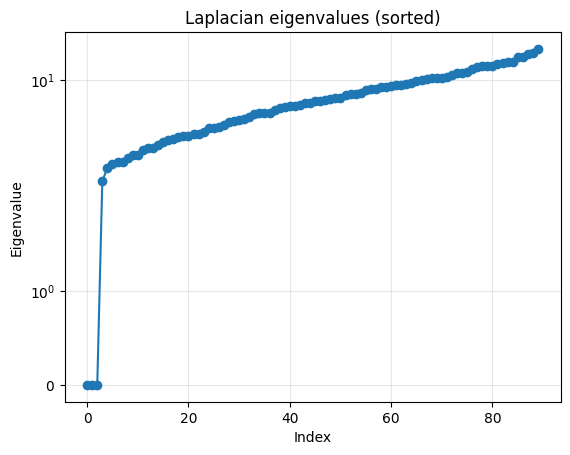

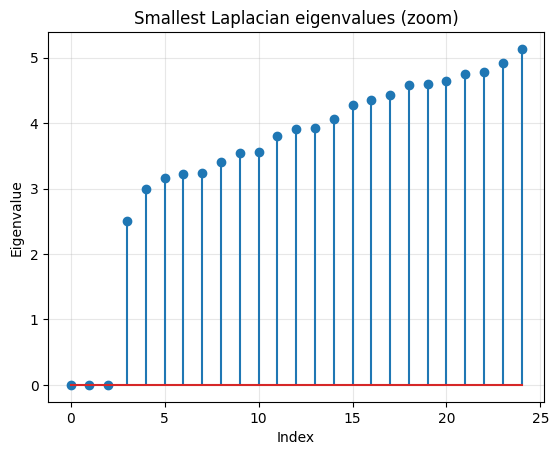

In [4]:
def laplacian_from_W(W: np.ndarray):
    """ Laplacian L = D - W.
    
        W : Adjacency matrix of the graph 
    """
    D = np.diag(W.sum(axis=1))
    return D - W

def normalized_laplacian_from_W(W: np.ndarray):

    """Normalized Laplacian L_sym = I - D^{-1/2} W D^{-1/2}."""
    
    d = W.sum(axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(d))

    I = np.eye(W.shape[0])
    # Formula in tp altegrad
    return I - D_inv_sqrt @ W @ D_inv_sqrt

def count_components_from_eigs(eigs, tol=1e-8):
    """#components = multiplicity of eigenvalue 0 (within tolerance)."""
    return int(np.sum(eigs < tol))

# -----------------------------
# Generate a graph with k connected components
# -----------------------------
n_per = 30
k = 3
p_in = 0.25   
p_out = 0.0   

sizes = [n_per] * k
P = np.full((k, k), p_out)
np.fill_diagonal(P, p_in)

G = nx.stochastic_block_model(sizes, P)
W = nx.to_numpy_array(G, weight=None)
np.fill_diagonal(W, 0.0)

# -----------------------------
# Laplacian and eigenvalues
# -----------------------------
L = laplacian_from_W(W) 

eigs = np.linalg.eigvalsh(L)  
num_cc = nx.number_connected_components(G)
num_cc_from_spec = count_components_from_eigs(eigs, tol=1e-8)

print("Connected components (networkx):", num_cc)
print("Connected components (spectral):", num_cc_from_spec)
print("Smallest eigenvalues:", eigs[:10])

# -----------------------------
# Plot graph and eigenvalues
# -----------------------------
plt.figure()
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=60, width=0.7)
plt.title(f"Graph (k={k} blocks, p_out={p_out})")
plt.axis("off")
plt.show()

plt.figure()
plt.plot(eigs, marker="o")
plt.yscale("symlog")  
plt.title("Laplacian eigenvalues (sorted)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
m = min(25, len(eigs))
plt.stem(range(m), eigs[:m])
plt.title("Smallest Laplacian eigenvalues (zoom)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()


SGL Algorithm, implemting the first algorithm of lambda and the correspinding second for updating the eigen values.

In [5]:
def update_lambda(d, beta, c1, c2):
    """
        Algorithm 1 as seen in the paper
    """

    d = np.asarray(d, dtype=float)
    q = d.size
    if q == 0:
        return d.copy()

    def g(x):
        return 0.5 * (x + np.sqrt(x*x + 4.0 / beta))

    def pav(d_seg):
        # blocks with (start,end,sum,count,lambda=g(mean))
        blocks = []
        for i, val in enumerate(d_seg):
            blocks.append([i, i, float(val), 1, g(float(val))])
            while len(blocks) >= 2 and blocks[-2][4] > blocks[-1][4]:
                b2 = blocks.pop()
                b1 = blocks.pop()
                s = b1[2] + b2[2]
                c = b1[3] + b2[3]
                blocks.append([b1[0], b2[1], s, c, g(s / c)])
        out = np.empty(len(d_seg), dtype=float)
        for a, b, s, c, lamv in blocks:
            out[a:b+1] = lamv
        return out

    left, right = 0, q
    lam = np.empty(q, dtype=float)

    while True:
        
        mid_raw = pav(d[left:right])

        # check if we need to clamp a prefix to c1
        low = np.where(mid_raw < c1)[0]
        if low.size > 0:
            left = left + low.max() + 1
            continue

        # check if we need to clamp a suffix to c2
        high = np.where(mid_raw > c2)[0]
        if high.size > 0:
            right = left + high.min()
            continue

        # feasible middle
        lam[:left] = c1
        lam[left:right] = mid_raw
        lam[right:] = c2
        return np.clip(lam, c1, c2)

Testing the correctness of the algorithm

In [6]:
def sanity_lambda():

    q = 10
    d = np.random.standard_normal(q) * 2  
    beta, c1, c2 = 400.0, 1e-3, 10.0

    lam = update_lambda(d, beta, c1, c2)

    print("min/max:", lam.min(), lam.max())
    print("monotone:", np.all(lam[:-1] <= lam[1:]))
    print("bounds ok:", lam[0] >= c1 and lam[-1] <= c2)

sanity_lambda()

min/max: 0.006361500376414919 0.2856173176834583
monotone: True
bounds ok: True


In [7]:
Y = np.random.randn(5, 5)
evals, U = np.linalg.eigh(Y)
D = U.T @ Y @ U
d = np.diag(D)
beta = 400
lam = update_lambda(d, beta = beta, c1 = 1e-3, c2 =  1e3)

minimizsation = - np.sum(np.log(lam)) + (np.linalg.norm(lam - d) ** 2) * beta / 2
print(minimizsation)

1353.0524109310145


We do get sorted values of the eigen vals that minimize the sum.


### SGL

In [8]:
def sgl(S: np.ndarray,
        k: int,
        alpha: float = 1e-3,
        beta: float = 10.0,
        eps: float = 1e-5,
        c1: float = 1e-5,
        c2: float = 1e4,
        w0: np.ndarray | None = None,
        tol = 1e-5):
    
    """
    Structured Graph Learning via Laplacian spectral constraints (SGL), Algorithm 2. :contentReference[oaicite:9]{index=9}

    Inputs (match paper):
      - S: sample covariance matrix (SCM)
      - k: number of connected components (k>=1), so q = p-k non-zero eigenvalues
      - c1, c2: bounds for non-zero Laplacian eigenvalues
      - beta: penalty parameter in relaxation
      - alpha: sparsity weight for reweighted l1 via log(eps + w_i)
      - eps: small positive number in log(eps + w_i)
      - w0: initialization for edge weights (nonnegative), length p(p-1)/2
      - stopping: relative change in w

    Returns:
      Theta: learned Laplacian matrix (p x p)
      w, U, lam: final iterates
    """
    
    S = np.asarray(S, dtype=float)
    p = S.shape[0]
    assert S.shape == (p, p)
    assert 0 <= k < p

    edges = edge_list(p)
    m = len(edges)

    if w0 is None:
        w = 0.1 * np.ones(m, dtype=float)
        
    else:
        w = np.asarray(w0, dtype=float).copy()
        assert w.shape == (m,)
        w = np.maximum(w, 0.0)

    L1 = 2.0 * p

    # initialize Theta, U, lambda from current Theta
    
    Lw = L_operator(w, p, edges)
    _, evecs = np.linalg.eigh(Lw)  
    U = evecs[:, k:]

    d0 = np.diag(U.T @ Lw @ U).copy()
    lam = update_lambda(d0, beta=beta, c1=c1, c2=c2)     

    while True:
        
        w_old = w.copy()
        
        D = np.zeros(shape=(lam.shape[0], lam.shape[0]))
        np.fill_diagonal(D, lam)
      
        c = L_adjoint((U @ D @ U.T) - (1 / beta) * S, p, edges)

        Lw = L_operator(w, p, edges) 
        grad = L_adjoint(Lw, p, edges) - c + (alpha / beta) * (1 / (eps + w))

        w = np.maximum(w - (grad / L1), 0.0)

        Lw = L_operator(w, p, edges)
        _, evecs = np.linalg.eigh(Lw)  
        U = evecs[:, k:]                      

        d = np.diag(U.T @ Lw @ U).copy()
        lam = update_lambda(d, beta=beta, c1=c1, c2=c2)

        if (np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-12)) < tol:
            break


    Theta = L_operator(w, p, edges)
    
    return Theta, w, U, lam

Application to noisy graphs

In [9]:
p = 20
k_true = 4

sizes = [p // k_true] * k_true  
W_true = np.zeros((p, p), dtype=float)

start = 0
for sz in sizes:
    idx = np.arange(start, start + sz)

    A = np.ones((sz, sz), dtype=float)
    np.fill_diagonal(A, 0.0)

    W = np.random.uniform(0.0, 1.0, size=(sz, sz))
    W =  (W + W.T) / 2          
    np.fill_diagonal(W, 0.0)

    W_true[np.ix_(idx, idx)] = A * W
    start += sz

Theta_true = laplacian_from_W(W_true)

In [10]:
kappa=0.05
p_edge=0.1

M = (np.random.random((p, p)) < p_edge).astype(float)
M = np.triu(M, 1)
M = M + M.T

W_er = np.random.uniform(low = 0.0, high = kappa, size=(p, p))
W_er = (W_er + W_er.T) / 2
np.fill_diagonal(W_er, 0.0)

W_er = M * W_er
Theta_er = laplacian_from_W(W_er)

In [11]:
Theta_noisy = Theta_true + Theta_er

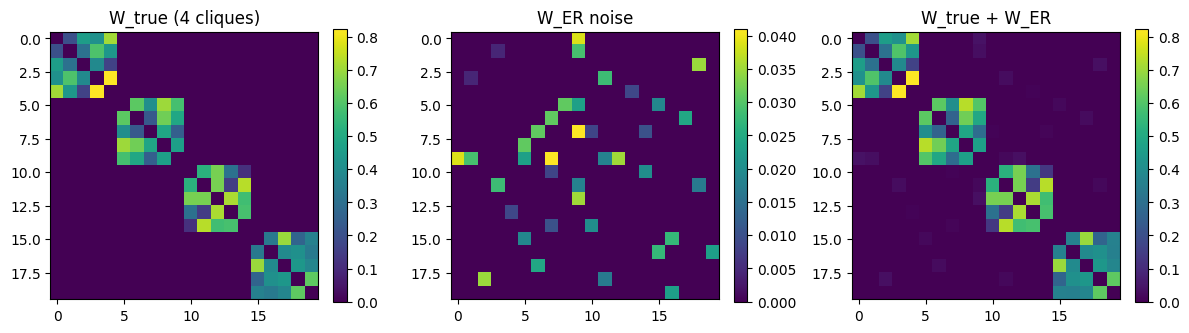

In [12]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(W_true)
plt.title("W_true (4 cliques)")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,2)
plt.imshow(W_er)
plt.title("W_ER noise")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,3)
plt.imshow(W_true + W_er)
plt.title("W_true + W_ER")
plt.colorbar(fraction=0.046)

plt.tight_layout()
plt.show()

We wish to learn W_true from W_noise. We first calculate the covariance matrix

In [13]:
n = 200 * p
J = np.ones((p, p)) / p
Sigma = np.linalg.inv(Theta_noisy + J)
X = np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=n)
S = np.cov(X, rowvar=False)
S_in = S + (1/3) * np.eye(p)

In [14]:
Theta_hat, w_hat, U_hat, lam_hat = sgl(
        S=S_in,
        k=k_true,
        alpha=0.01,
        beta=400.0,
        eps=1e-3,
        c1=1e-5,
        c2=1e4,
        tol=1e-5,
    )

In [15]:
G_true = nx.from_numpy_array(W_true)
W_hat = adjacency_from_theta(Theta_hat, thr=1e-6)
G_hat = nx.from_numpy_array(W_hat)

In [16]:
print("True components (nx):", nx.number_connected_components(G_true))
print("Learned components (nx):", nx.number_connected_components(G_hat))

True components (nx): 4
Learned components (nx): 4


In [17]:
# eigs, vecs = np.linalg.eigh(Theta_hat)
# U_k = vecs[:, :k_true]
# order = np.argsort(U_k[:, 0])  
# W_hat = W_hat[np.ix_(order, order)]

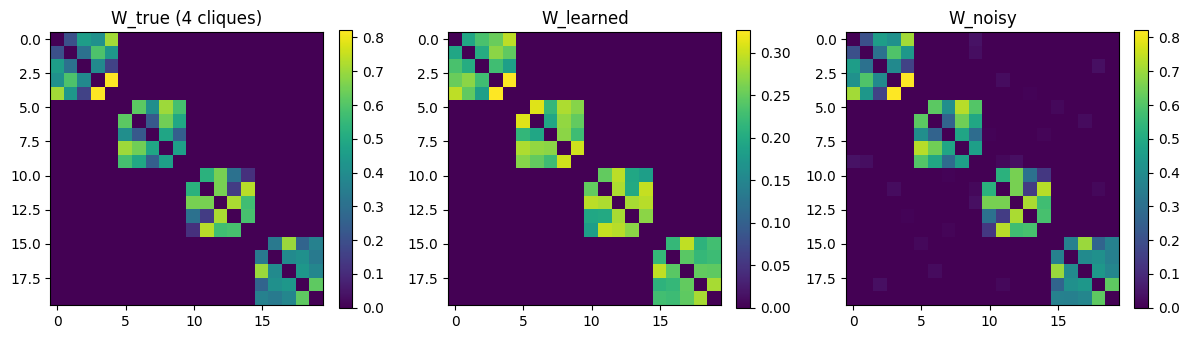

In [18]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(W_true)
plt.title("W_true (4 cliques)")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,2)
plt.imshow(W_hat)
plt.title("W_learned")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,3)
plt.imshow(W_true + W_er)
plt.title("W_noisy")
plt.colorbar(fraction=0.046)

plt.tight_layout()
plt.show()

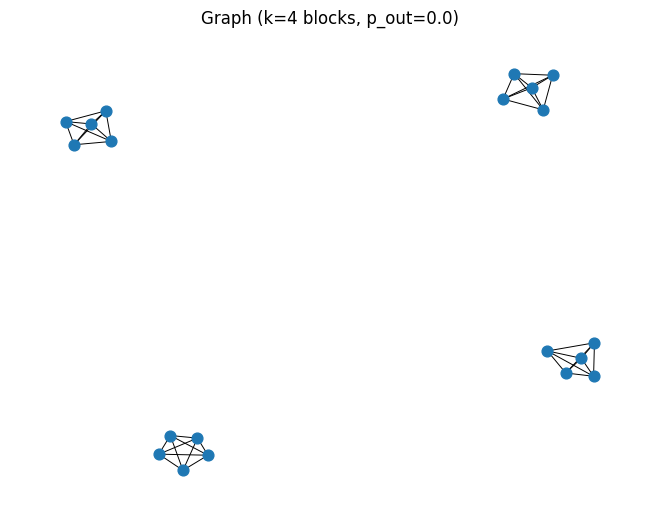

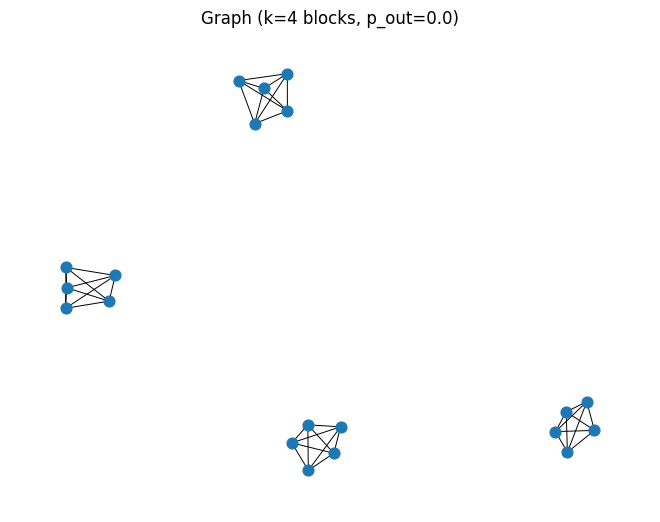

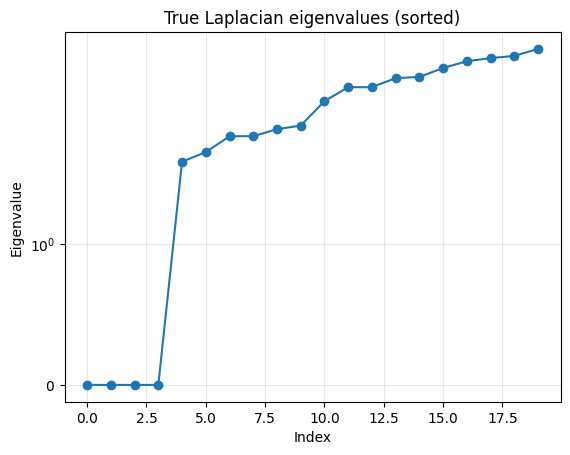

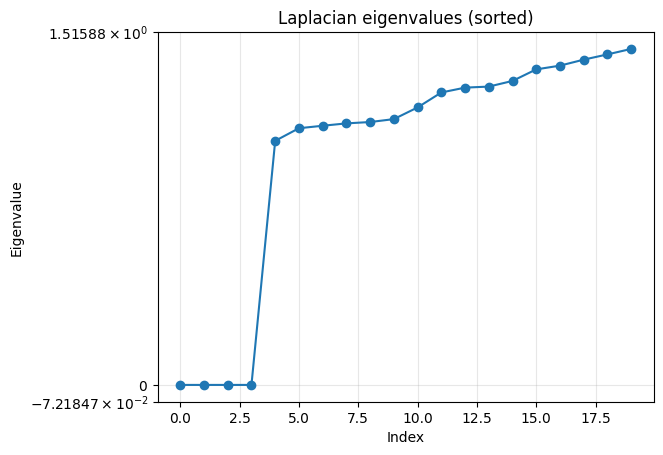

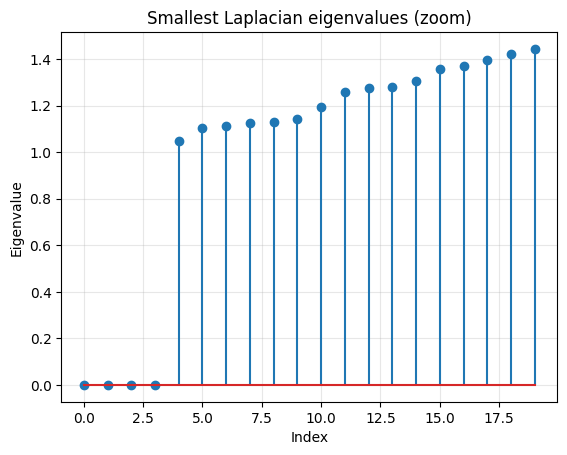

In [19]:
L_hat = laplacian_from_W(W_hat)
L_true = laplacian_from_W(W_true)
eigs_hat = np.linalg.eigvalsh(L_hat)
eigs_true = np.linalg.eigvalsh(L_true)

plt.figure()
pos = nx.spring_layout(G_true)
nx.draw(G_true, pos, node_size=60, width=0.7)
plt.title(f"Graph (k={k_true} blocks, p_out={p_out})")
plt.axis("off")
plt.show()

plt.figure()
pos = nx.spring_layout(G_hat)
nx.draw(G_hat, pos, node_size=60, width=0.7)
plt.title(f"Graph (k={k_true} blocks, p_out={p_out})")
plt.axis("off")
plt.show()

plt.figure()
plt.plot(eigs_true, marker="o")
plt.yscale("symlog")  
plt.title("True Laplacian eigenvalues (sorted)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.plot(eigs_hat, marker="o")
plt.yscale("symlog")  
plt.title("Laplacian eigenvalues (sorted)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
m = min(25, len(eigs_hat))
plt.stem(range(m), eigs_hat[:m])
plt.title("Smallest Laplacian eigenvalues (zoom)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

In [20]:
p = 49
k_true = 7

sizes = [p // k_true] * k_true  
W_true = np.zeros((p, p), dtype=float)

start = 0
for sz in sizes:
    idx = np.arange(start, start + sz)

    A = np.ones((sz, sz), dtype=float)
    np.fill_diagonal(A, 0.0)

    W = np.random.uniform(0.0, 1.0, size=(sz, sz))
    W =  (W + W.T) / 2          
    np.fill_diagonal(W, 0.0)

    W_true[np.ix_(idx, idx)] = A * W
    start += sz

Theta_true = laplacian_from_W(W_true)

In [21]:
kappa=0.45
p_edge=1.0

M = (np.random.random((p, p)) < p_edge).astype(float)
M = np.triu(M, 1)
M = M + M.T

W_er = np.random.uniform(low = 0.0, high = kappa, size=(p, p))
W_er = (W_er + W_er.T) / 2
np.fill_diagonal(W_er, 0.0)

W_er = M * W_er
Theta_er = laplacian_from_W(W_er)

In [22]:
Theta_noisy = Theta_true + Theta_er

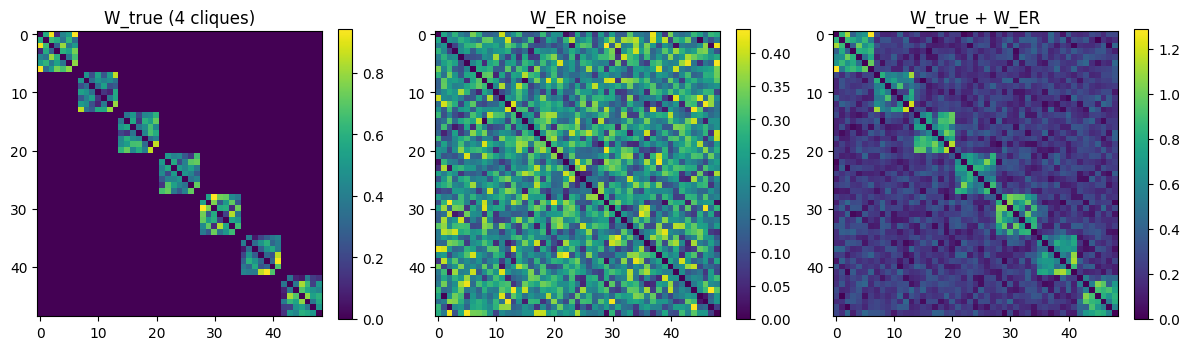

In [23]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(W_true)
plt.title("W_true (4 cliques)")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,2)
plt.imshow(W_er)
plt.title("W_ER noise")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,3)
plt.imshow(W_true + W_er)
plt.title("W_true + W_ER")
plt.colorbar(fraction=0.046)

plt.tight_layout()
plt.show()

In [24]:
n = 30 * p
J = np.ones((p, p)) / p
Sigma = np.linalg.inv(Theta_noisy + J)
X = np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=n)
S = np.cov(X, rowvar=False)
S_in = S + (1/3) * np.eye(p)

In [25]:
Theta_hat, w_hat, U_hat, lam_hat = sgl(
        S=S_in,
        k=2,
        alpha=0.01,
        beta=400.0,
        eps=1e-3,
        c1=1e-5,
        c2=1e4,
        tol=1e-5,
    )

KeyboardInterrupt: 

In [ ]:
G_true = nx.from_numpy_array(W_true)
W_hat = adjacency_from_theta(Theta_hat, thr=1e-5)
G_hat = nx.from_numpy_array(W_hat)

In [ ]:
print("True components (nx):", nx.number_connected_components(G_true))
print("Learned components (nx):", nx.number_connected_components(G_hat))

True components (nx): 7
Learned components (nx): 2


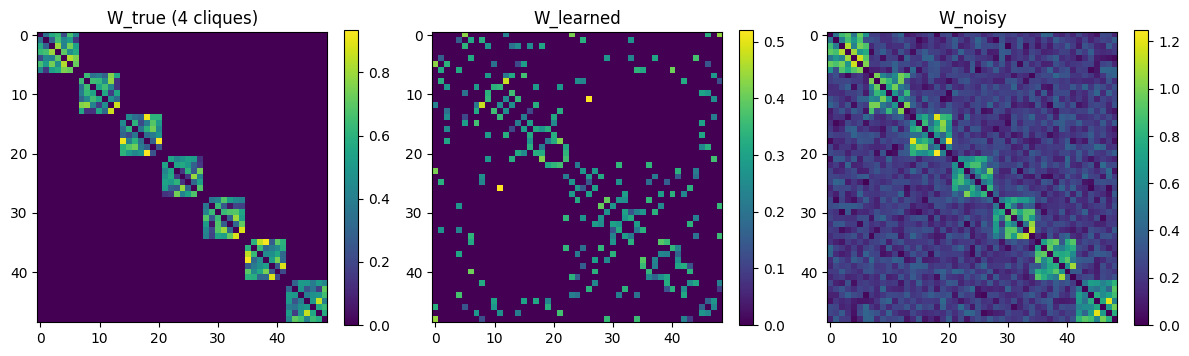

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(W_true)
plt.title("W_true (4 cliques)")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,2)
plt.imshow(W_hat)
plt.title("W_learned")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,3)
plt.imshow(W_true + W_er)
plt.title("W_noisy")
plt.colorbar(fraction=0.046)

plt.tight_layout()
plt.show()

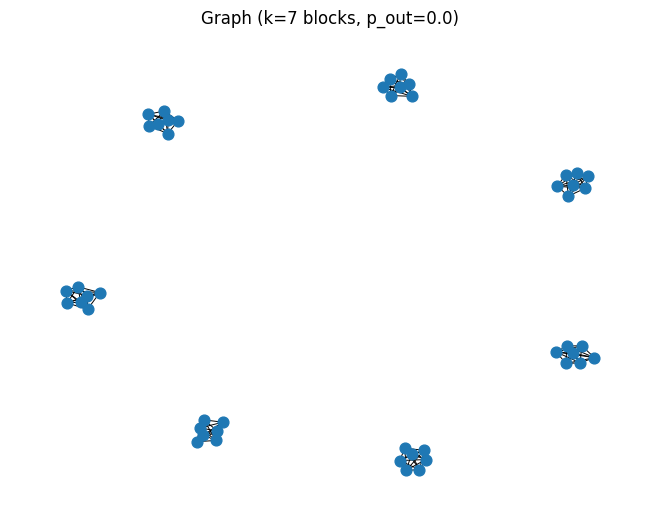

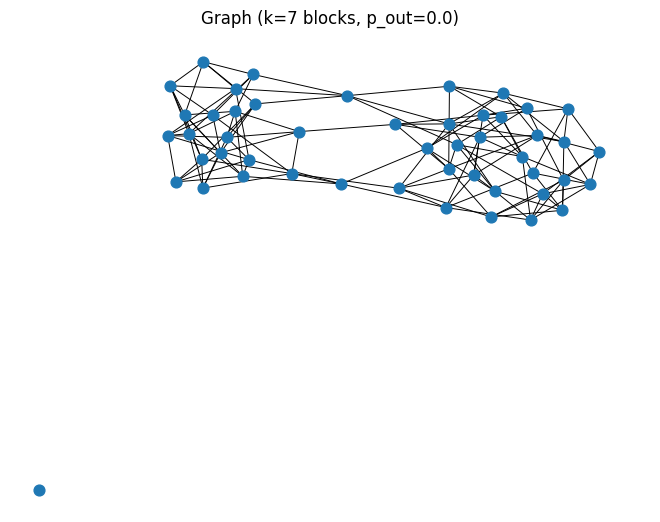

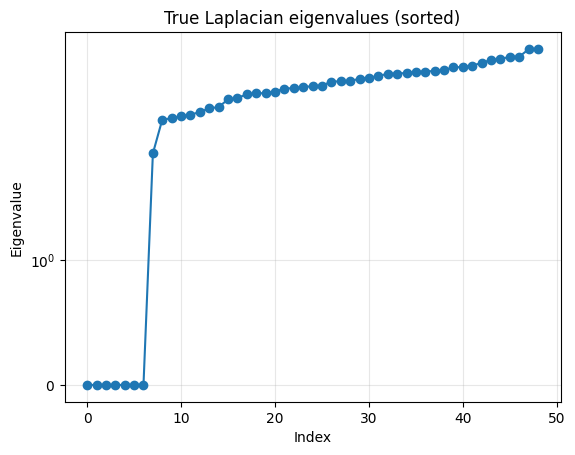

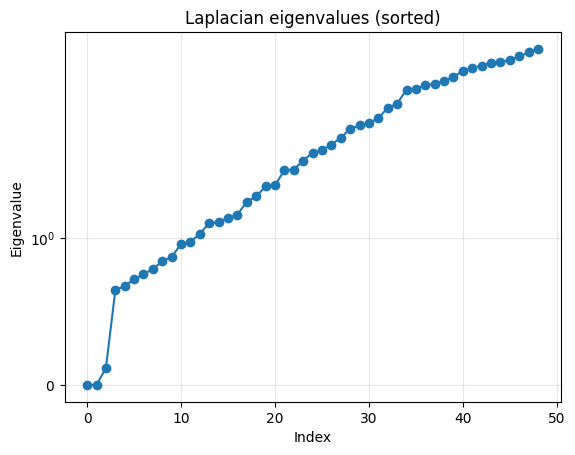

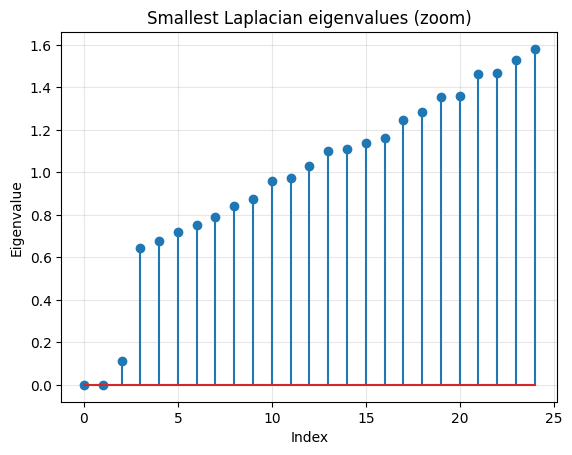

In [ ]:
L_hat = laplacian_from_W(W_hat)
L_true = laplacian_from_W(W_true)
eigs_hat = np.linalg.eigvalsh(L_hat)
eigs_true = np.linalg.eigvalsh(L_true)

plt.figure()
pos = nx.spring_layout(G_true)
nx.draw(G_true, pos, node_size=60, width=0.7)
plt.title(f"Graph (k={k_true} blocks, p_out={p_out})")
plt.axis("off")
plt.show()

plt.figure()
pos = nx.spring_layout(G_hat)
nx.draw(G_hat, pos, node_size=60, width=0.7)
plt.title(f"Graph (k={k_true} blocks, p_out={p_out})")
plt.axis("off")
plt.show()

plt.figure()
plt.plot(eigs_true, marker="o")
plt.yscale("symlog")  
plt.title("True Laplacian eigenvalues (sorted)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.plot(eigs_hat, marker="o")
plt.yscale("symlog")  
plt.title("Laplacian eigenvalues (sorted)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
m = min(25, len(eigs_hat))
plt.stem(range(m), eigs_hat[:m])
plt.title("Smallest Laplacian eigenvalues (zoom)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

### Animal Dataset

In [122]:
A_animals = np.loadtxt("./AwA2-base/Animals_with_Attributes2/predicate-matrix-binary.txt")  
with open("./AwA2-base/Animals_with_Attributes2/classes.txt", "r") as f:
    class_names = [line.strip() for line in f]

In [119]:
A_animals = np.asarray(A_animals) 
print(f"The shape of the dataset is: {A_animals.shape}")

X_animals = A_animals.T
Xc = X_animals - X_animals.mean(axis=0, keepdims=True)
std = Xc.std(axis=0, keepdims=True)

Xz = Xc / std

S_animals = (Xz.T @ Xz) / Xz.shape[0]
p = S_animals.shape[0]
S_in_animals = S_animals + (1/3) * np.eye(p)

Theta_hat_animals, w_hat, U_hat, lam_hat = sgl(
    S=S_in_animals,
    k=5,
    alpha=0.0,
    beta=0.5,
    eps=1e-3,
    c1=1e-3,
    c2=1e3,
    tol=1e-5
)

The shape of the dataset is: (50, 85)


In [115]:
W_hat_animals = adjacency_from_theta(Theta_hat_animals, thr = 1e-9)
G_hat_animals = nx.from_numpy_array(W_hat_animals)

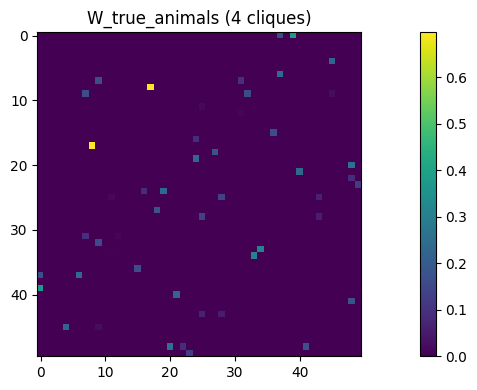

In [116]:
plt.figure(figsize=(12,4))


plt.imshow(W_hat_animals)
plt.title("W_true_animals (4 cliques)")
plt.colorbar(fraction=0.046)

plt.tight_layout()
plt.show()

In [117]:
print("Learned components (nx):", nx.number_connected_components(G_hat_animals))

Learned components (nx): 26


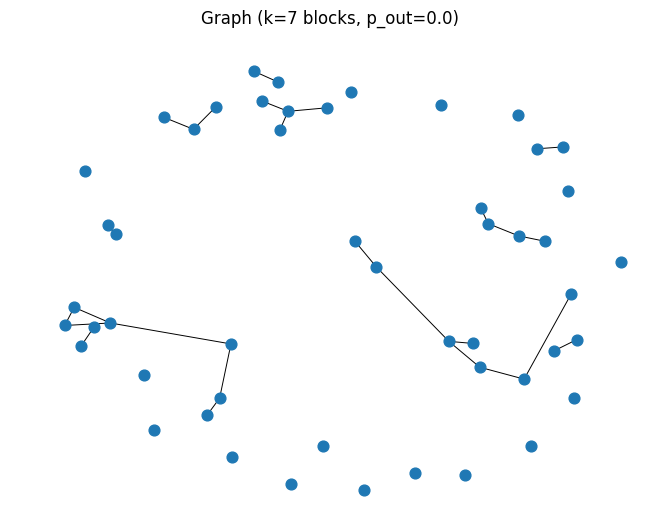

In [118]:
plt.figure()
pos = nx.spring_layout(G_hat_animals)
nx.draw(G_hat_animals, pos, node_size=60, width=0.7)
plt.title(f"Graph (k={k_true} blocks, p_out={p_out})")
plt.axis("off")
plt.show()

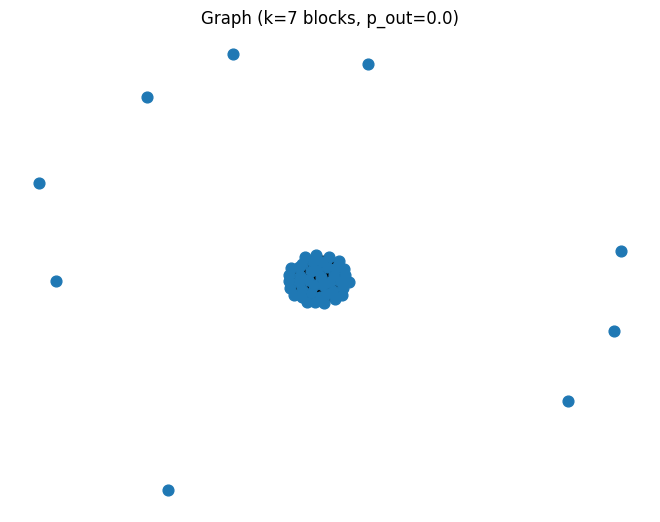

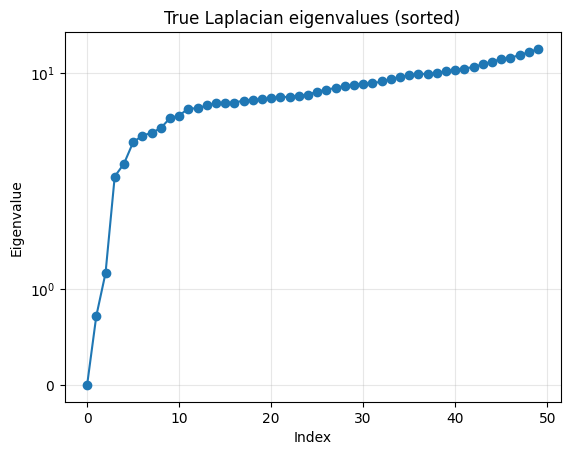

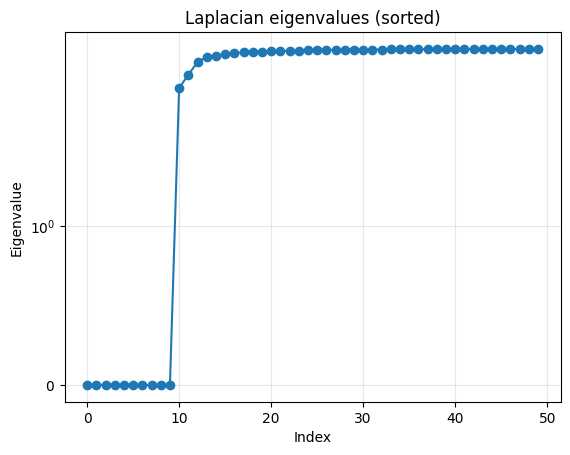

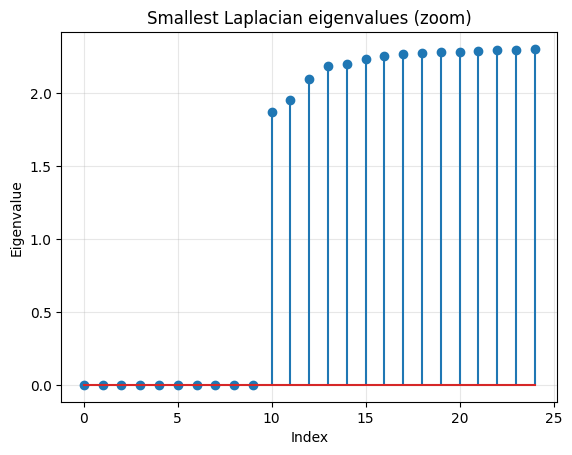

In [ ]:
L_hat_animals = laplacian_from_W(W_hat_animals)
L_true_animals = laplacian_from_W(W_true_animals)

eigs_hat_animals = np.linalg.eigvalsh(L_hat_animals)
eigs_true_animals = np.linalg.eigvalsh(L_true_animals)

plt.figure()
pos = nx.spring_layout(G_hat_animals)
nx.draw(G_hat_animals, pos, node_size=60, width=0.7)
plt.title(f"Graph (k={k_true} blocks, p_out={p_out})")
plt.axis("off")
plt.show()

plt.figure()
plt.plot(eigs_true_animals, marker="o")
plt.yscale("symlog")  
plt.title("True Laplacian eigenvalues (sorted)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.plot(eigs_hat_animals, marker="o")
plt.yscale("symlog")  
plt.title("Laplacian eigenvalues (sorted)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
m = min(25, len(eigs_hat_animals))
plt.stem(range(m), eigs_hat_animals[:m])
plt.title("Smallest Laplacian eigenvalues (zoom)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

### SGA Algorithm

In [ ]:
def laplacian_from_W(W: np.ndarray):
    D = np.diag(W.sum(axis=1))
    return D - W

def count_components_from_eigs(eigs, tol=1e-8):
    return int(np.sum(eigs < tol))

Adjacency algorithm

In [ ]:
def A_operator(w: np.ndarray, p: int, edges=None):
    """
    Adjacency operator A : w -> W = Aw
    Off-diagonal: W_ij = w_k, diag = 0 (See page 19)
    """

    if edges is None:
        edges = edge_list(p)
        
    W = np.zeros((p, p), dtype=float)
    
    for wk, (i, j) in zip(w, edges):

        W[i, j] = wk
        W[j, i] = wk
    
    np.fill_diagonal(W, 0.0)

    return W

def A_adjoint(Y: np.ndarray, p: int, edges=None):
    """
    Adjoint A* : Y -> vector where each entry is Y_ij + Y_ji (See paper page 19)
    """

    if edges is None:
        edges = edge_list(p)

    out = np.zeros(len(edges), dtype=float)
    
    for k, (i, j) in enumerate(edges):
        out[k] = Y[i, j] + Y[j, i]
    
    return out

Testing the correctness of the adjacency operator.

In [ ]:
p = 4
edges = edge_list(p)

m = p*(p-1)//2
w = np.arange(1, m+1)
A = A_operator(w, p, edges)
Y = np.random.randn(p, p)

left = np.sum(A * Y)  
right = np.dot(w, A_adjoint(Y, p, edges))
print("adjoint error:", np.isclose(left - right, 0), np.abs(left - right))

adjoint error: True 2.6645352591003757e-15


In [ ]:
def V_from_Aw(Aw: np.ndarray, z: int):
        
        _, evecs = np.linalg.eigh(Aw)  
        a = (p - z) // 2
        b = (p + z) // 2
        
        V = np.concatenate([evecs[:, :a], evecs[:, b:]], axis=1)
        return V

In [ ]:
def update_psi_with_update_lambda(e, c1, c2, beta_lam):

        """
        Adaptation of the lambda Algo
        """

        e = np.asarray(e, float)
        b = e.size
        assert b % 2 == 0
        half = b // 2

        
        t = (e[:half] - e[::-1][:half]) / 2
        
        t_proj_inc = update_lambda(-t, beta=beta_lam, c1=-c1, c2=-c2)
        t_proj = -t_proj_inc

        psi = np.concatenate([t_proj, -t_proj[::-1]])
        return psi

In [ ]:
def sga(S: np.ndarray,
        alpha: float = 1e-3,
        gamma: float = 10.0,          
        beta: float = 50.0,       
        eps: float = 1e-5,
        c1: float = 1.0,              
        c2: float = 0.1,              
        z: int = 0,                   
        w0: np.ndarray | None = None,
        tol: float = 1e-5):      

    """
    SGA Algporithm

    Inputs (match paper):
      - S: sample covariance matrix (SCM)
      - k: number of connected components (k>=1), so q = p-k non-zero eigenvalues
      - c1, c2: bounds for non-zero Laplacian eigenvalues
      - beta: penalty parameter in relaxation
      - alpha: sparsity weight for reweighted l1 via log(eps + w_i)
      - eps: small positive number in log(eps + w_i)
      - w0: initialization for edge weights (nonnegative), length p(p-1)/2
      - stopping: relative change in w

    Returns:
      Theta: learned Laplacian matrix (p x p)
      w, U, lam: final iterates
    """       

    S = np.asarray(S, dtype=float)
    p = S.shape[0]
    assert S.shape == (p, p)

    edges = edge_list(p)
    m = len(edges)

    if w0 is None:
        w = 0.1 * np.ones(m, dtype=float)
    else:
        w = np.maximum(np.asarray(w0, dtype=float).copy(), 0.0)

    J = np.ones((p, p), dtype=float) / p
    L = 2.0 * p
   
    Aw = A_operator(w, p, edges)
    

    V = V_from_Aw(Aw, z=z)
    
    e = np.diag(V.T @ Aw @ V).copy()

    psi = update_psi_with_update_lambda(e, c1=c1, c2=c2, beta_lam=beta)

    while True:

        w_old = w.copy()

        Lmat = L_operator(w, p, edges)
        Aw = A_operator(w, p, edges)
        
        M = Lmat + J
        Minv = np.linalg.inv(M)
        grad_f1 = - (1.0 / gamma) * L_adjoint(Minv, p, edges)

        
        c_tilde = A_adjoint((V * psi) @ V.T, p, edges) - (1.0 / gamma) * L_adjoint(S, p, edges)
        grad_f2 = A_adjoint(Aw, p, edges) - c_tilde

        
        grad_f3 = (alpha / gamma) * (1.0 / (eps + w))

        grad = grad_f1 + grad_f2 + grad_f3
        w = np.maximum(w - (grad / L), 0.0)

        Aw = A_operator(w, p, edges)
        V = V_from_Aw(Aw, z=z)
 
        e = np.diag(V.T @ Aw @ V).copy()
        psi = update_psi_with_update_lambda(e, c1=c1, c2=c2, beta_lam=beta)

        if np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-12) < tol:
            break


    Theta_hat = L_operator(w, p, edges)
    return Theta_hat, w, V, psi

### SGLA Algorithm

In [ ]:
def sgla(S: np.ndarray,
        k : int,
        alpha: float = 1e-3,
        gamma: float = 10.0,          
        beta: float = 50.0,       
        eps: float = 1e-5,
        c1: float = 1.0,              
        c2: float = 0.1,              
        z: int = 0,                   
        w0: np.ndarray | None = None,
        tol: float = 1e-5):      

    """
    SGA Algporithm

    Inputs (match paper):
      - S: sample covariance matrix (SCM)
      - k: number of connected components (k>=1), so q = p-k non-zero eigenvalues
      - c1, c2: bounds for non-zero Laplacian eigenvalues
      - beta: penalty parameter in relaxation
      - alpha: sparsity weight for reweighted l1 via log(eps + w_i)
      - eps: small positive number in log(eps + w_i)
      - w0: initialization for edge weights (nonnegative), length p(p-1)/2
      - stopping: relative change in w

    Returns:
      Theta: learned Laplacian matrix (p x p)
      w, U, lam: final iterates
    """       

    S = np.asarray(S, dtype=float)
    p = S.shape[0]
    assert S.shape == (p, p)

    edges = edge_list(p)
    m = len(edges)

    if w0 is None:
        w = 0.1 * np.ones(m, dtype=float)
    else:
        w = np.maximum(np.asarray(w0, dtype=float).copy(), 0.0)

    J = np.ones((p, p), dtype=float) / p
    L = 2 * (p * beta + gamma)

    Aw = A_operator(w, p, edges)
    Lw = L_operator(w, p, edges)

    V = V_from_Aw(Aw, z=z)
    _, U = np.linalg.eigh(Lw)
    U = U[:, k :]
    
    e = np.diag(V.T @ Aw @ V).copy()
    d = np.diag(U.T @ Lw @ U).copy()

    psi = update_psi_with_update_lambda(e, c1=c1, c2=c2, beta_lam=beta)
    lam = update_lambda(d, c1 = c1, c2 = c2, beta=beta)

    while True:

        w_old = w.copy()

        Lw = L_operator(w, p, edges)
        Aw = A_operator(w, p, edges)
        
        c_1 = beta * L_adjoint((U * lam) @ U.T - S / beta, p = p, edges=edges)
        c_2 = gamma * A_adjoint((V * psi) @ V.T, p = p, edges = edges)
        b_1 = alpha / (eps + w)

        grad_f1 = beta * L_adjoint(Lw, p = p, edges=edges) - c_1 + b_1
        grad_f2 = gamma * A_adjoint(Aw, p = p, edges = edges) - c_2

        grad = grad_f1 + grad_f2 
        w = np.maximum(w - (grad / L), 0.0)

        Aw = A_operator(w, p, edges)
        V = V_from_Aw(Aw, z=z)
        _, U = np.linalg.eigh(Lw)
        U = U[:, k :]

        d = np.diag(U.T @ Lw @ U).copy()
        e = np.diag(V.T @ Aw @ V).copy()
        psi = update_psi_with_update_lambda(e, c1=c1, c2=c2, beta_lam=beta)
        lam = update_lambda(d, c1 = c1, c2 = c2, beta = beta)

        if np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-12) < tol:
            break

    Theta_hat = L_operator(w, p, edges)
    return Theta_hat, w, V, psi